# Detección y Conteo de Árboles con YOLOv8

Este notebook implementa un sistema de detección y conteo de árboles a partir de imágenes satelitales, utilizando el modelo YOLOv8 de Ultralytics y la biblioteca `supervision` para la visualización de resultados.


## Instalación de dependencias

Instalamos las bibliotecas necesarias: `ultralytics` para usar YOLOv8, y `supervision` para anotaciones visuales.

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Instalar YOLOv8

In [4]:
!pip install "ultralytics<=8.3.40"

from IPython import display
display.clear_output()

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


## Instalar Supervision

In [5]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.25.1


## Descomprimir los pesos del modelo

Descomprimimos el archivo `weights.zip` para acceder a los archivos de pesos del modelo entrenado.

In [6]:
!unzip weights.zip

Archive:  weights.zip
   creating: runs/detect/train/weights/
  inflating: runs/detect/train/weights/best.pt  
  inflating: runs/detect/train/weights/last.pt  


## Carga del modelo entrenado

Se carga el modelo YOLOv8 previamente entrenado desde la ruta `best.pt`, ubicada dentro del directorio de resultados de entrenamiento. Luego, se aplica la función `fuse()` para optimizar el modelo antes de la inferencia.

In [ ]:
MODEL = f"{HOME}/runs/detect/train/weights/best.pt"

In [7]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


## Detección y Anotación de Árboles en Imagen Satelital

Se realiza la detección de árboles en una imagen satelital utilizando el modelo YOLOv8 previamente cargado. Se utilizan las herramientas de la librería `supervision` para visualizar los resultados mediante cajas delimitadoras y etiquetas con confianza.


0: 800x1280 19 Trees, 34.9ms
Speed: 7.2ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 800, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


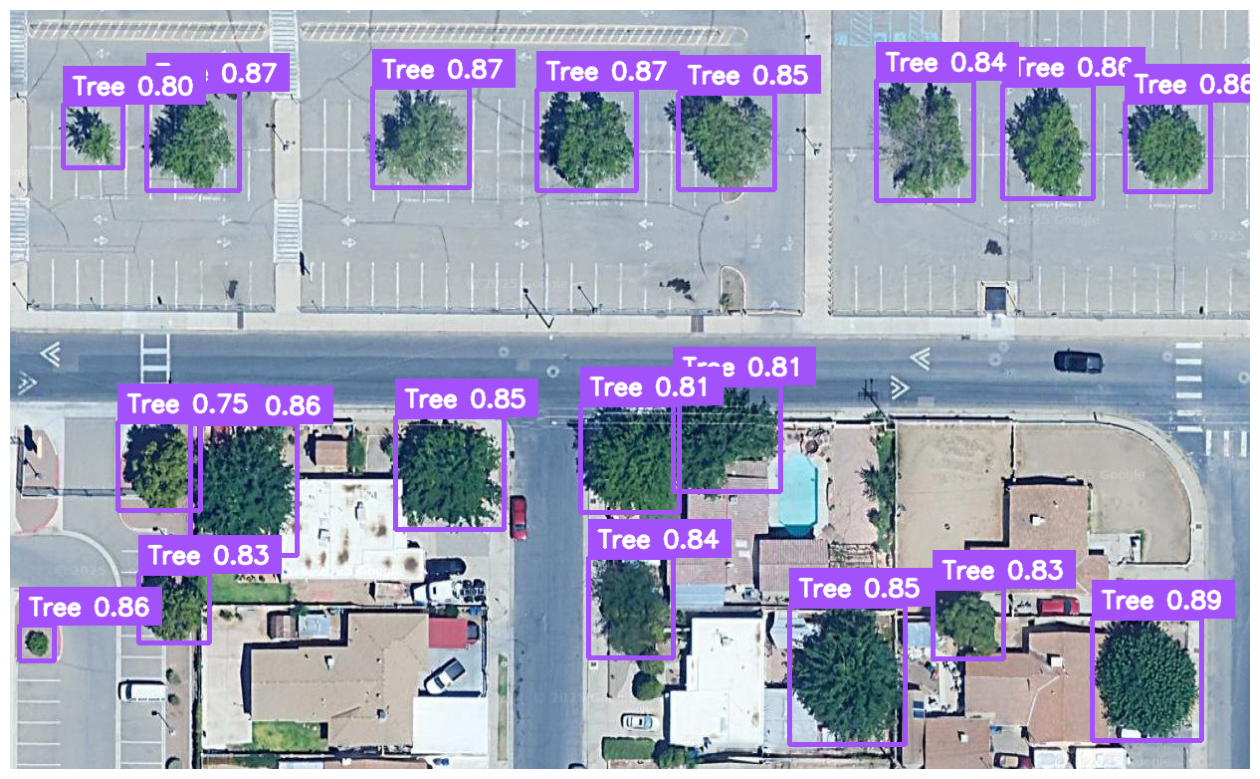

In [ ]:
import supervision as sv
import cv2
import numpy as np

# Cargar la imagen directamente desde archivo
SOURCE_IMAGE_PATH = "trees2.jpg"
frame = cv2.imread(SOURCE_IMAGE_PATH)

# Verificar que se haya cargado bien
if frame is None:
    raise ValueError(f"No se pudo cargar la imagen en {SOURCE_IMAGE_PATH}")

# Detección (requiere que hayas cargado previamente un modelo YOLO en la variable 'model')
results = model(frame, imgsz=1280)[0]

# Convertir resultados a formato supervision
detections = sv.Detections.from_ultralytics(results)

# Filtrar por clase (por ejemplo, clase 0)
detections = detections[detections.class_id == 0]

# Crear anotadores
box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=0.8)

# Generar etiquetas de texto
labels = [
    f"{model.names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _ in detections
]

# Dibujar cajas y etiquetas en la imagen
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

# Mostrar imagen anotada
%matplotlib inline
sv.plot_image(frame, (16, 16))


## Conteo total de árboles detectados

Se imprime en consola la cantidad total de árboles detectados en la imagen. Esto se obtiene contando el número de detecciones filtradas por clase (en este caso, clase `0`, correspondiente a árboles).

In [ ]:
print("El número de arboles es: ", len(detections))

19